# Preparing small dataset for testing softwares

1. Need small tif with corresponding mask
2. adjusted adata

In [14]:
import tifffile as tff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import os
import anndata as ad
import pickle as pk
from tqdm import tqdm
from scipy import signal, ndimage
from imantics import Polygons, Mask
import json

In [3]:
def erode_mask(masks):
    masks_erode = masks.copy()
    for i in tqdm(np.arange(1, masks.shape[0]-1)):
        for j in np.arange(1, masks.shape[1]-1):
            if (masks[i,j-1] != masks[i,j+1]) and (min((masks[i,j-1], masks[i,j+1])) != 0):
                masks_erode[i,j] = 0
            if (masks[i-1,j] != masks[i+1,j]) and (min((masks[i-1,j], masks[i+1,j])) != 0):
                masks_erode[i,j] = 0
    # drop small cells
    unique, counts = np.unique(masks_erode, return_counts=True)
    c =np.asarray((unique, counts)).T
    drop_index = c[np.where(c[:,1] < 50),0]
    masks_erode[np.isin(masks_erode, drop_index[0])] = 0
    return masks_erode

In [2]:
s = 'R1_reg1'
img = tff.TiffFile("forQuPath/Data/"+s+"/full_input_codex.qptiff")
m_list = pd.read_table("forQuPath/channelNames.txt", header=None)

In [3]:
dat = img.series[0].asarray()
dat.shape

(44, 7488, 10026)

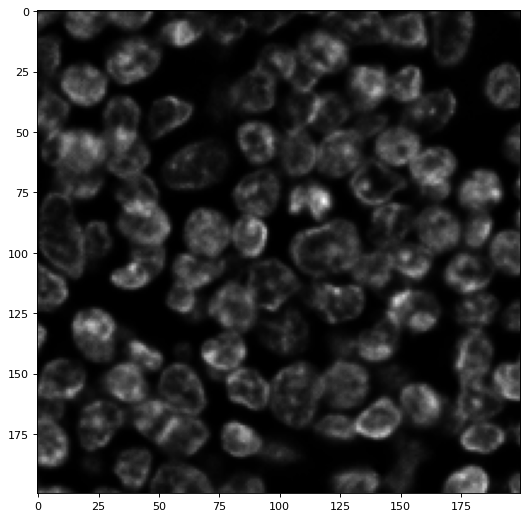

In [13]:
plt.figure(figsize=(12, 8), dpi=80)
# plt.imshow(dat >= global_thresh, cmap='gray')
plt.imshow(dat[0,0:200,0:200], cmap='gray')

In [9]:
# the mask
with open("../Data/CellSeg/output/visual_output/R1_reg1_inputgrowth5mask.pckl", 'rb') as f:
    masks = pk.load(f)
masks.shape

(7480, 10023)

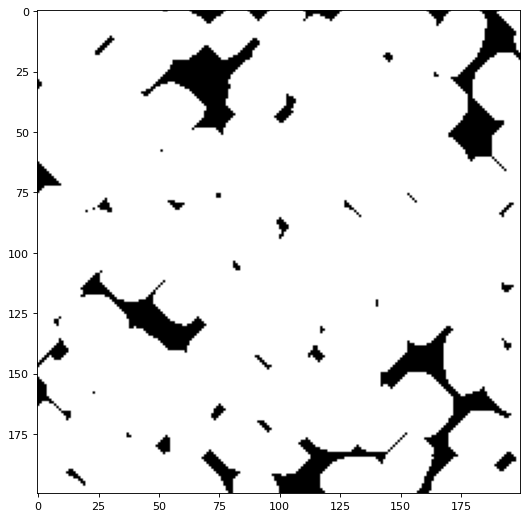

In [4]:
plt.figure(figsize=(12, 8), dpi=80)
# plt.imshow(dat >= global_thresh, cmap='gray')
plt.imshow(masks[0:200,0:200] > 0, cmap='gray')

In [19]:
mask_erode = erode_mask(masks)

100%|██████████| 7478/7478 [02:52<00:00, 43.28it/s]


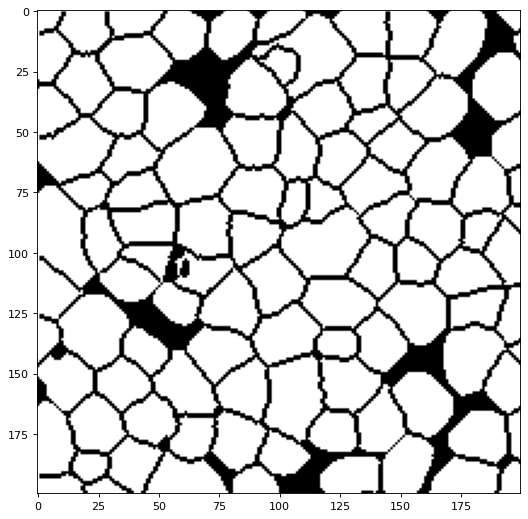

In [6]:
plt.figure(figsize=(12, 8), dpi=80)
# plt.imshow(dat >= global_thresh, cmap='gray')
plt.imshow(masks_erode[0:200,0:200] > 0, cmap='gray')

(7480, 10023)


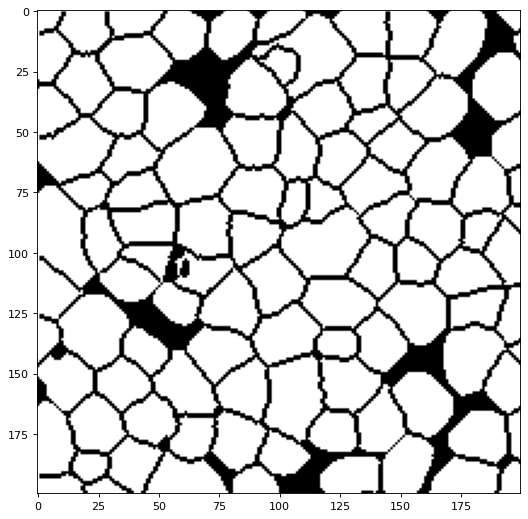

In [22]:
bit_mask = mask_erode.copy()
bit_mask[bit_mask > 0] = 255
print(bit_mask.shape)
plt.figure(figsize=(12, 8), dpi=80)
# plt.imshow(dat >= global_thresh, cmap='gray')
plt.imshow(bit_mask[0:200,0:200], cmap='gray')

In [27]:
dat_small = dat[:,0:2000,0:2000]
masks_small = masks[0:2000,0:2000]
bit_masks_small = bit_mask[0:2000,0:2000]

In [25]:
# loading from gh-pages
masks = tff.TiffFile("../data/test/mask_small.tiff")
masks = masks.asarray()
masks = masks.astype(np.dtype("<u2"))
masks = np.transpose(masks, axes=(1, 0))
masks.shape

(2000, 2000)

In [26]:
masks_erode = erode_mask(masks)
masks_erode = ndimage.binary_erosion(masks_erode, structure=np.ones((3,3)), iterations=1).astype(int) * masks_erode

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1998/1998 [00:07<00:00, 253.38it/s]


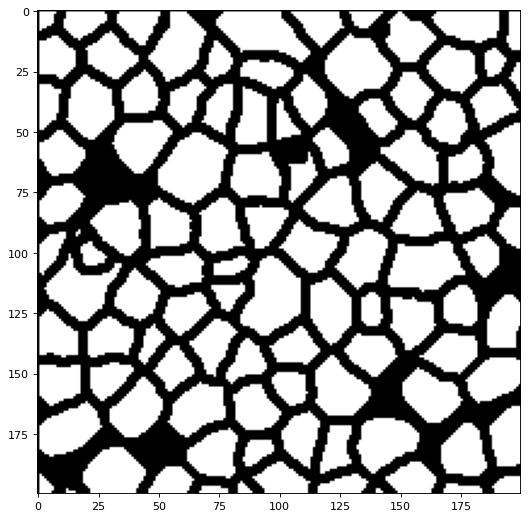

In [27]:
plt.figure(figsize=(12, 8), dpi=80)
# plt.imshow(dat >= global_thresh, cmap='gray')
plt.imshow(masks_erode[0:200,0:200] > 0, cmap='gray')

In [9]:
# now getting the polygons
np.unique(masks_erode[0:200,0:200])

array([   0,   21,   39,   60,   62,   83,   87,   97,   99,  100,  101,
        113,  116,  133,  134,  150,  154,  161,  175,  223,  228,  238,
        252,  254,  280,  288,  317,  325,  337,  356,  382,  414,  415,
        417,  421,  442,  456,  485,  511,  521,  541,  564,  596,  597,
        603,  623,  627,  629,  632,  661,  685,  700,  717,  721,  728,
        738,  754,  768,  771,  784,  790,  800,  802,  824,  828,  840,
        841,  860,  876,  886,  993, 1011, 1034, 1057, 1064, 1069, 1077,
       1093, 1097, 1099, 1100, 1120, 1135, 1152, 1173, 1174, 1177, 1200,
       1208, 1209, 1227, 1234, 1236, 1245, 1249, 1251, 1254, 1261, 1287,
       1295, 1308, 1310, 1311, 1320, 1331, 1348])

In [10]:
poly = Mask(masks_erode==21).polygons()

In [22]:
poly.points[0].tolist()

[[1511, 1578],
 [1511, 1582],
 [1512, 1583],
 [1512, 1588],
 [1513, 1588],
 [1519, 1582],
 [1519, 1581],
 [1516, 1578]]

In [28]:
segments = {}
for i in tqdm(np.unique(masks_erode)):
    if i == 0:
        continue
    poly = Mask(masks_erode==i).polygons()
    segments[int(i)] = poly.points[0].tolist() # should hopefully only be 1 cell...

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10532/10532 [00:55<00:00, 188.41it/s]


In [29]:
with open("../data/test/converted/test_segmentations.json", "w") as f:
    json.dump(segments, f)

True

## adata prep

In [21]:
adata = ad.read_h5ad("../outs/neighborhood_analysis/R1_reg1/gated_dat_full.h5ad")

In [28]:
np.unique(masks[0:200,0:200])

array([   0,   21,   39,   60,   62,   83,   87,   97,   99,  100,  101,
        113,  116,  133,  134,  150,  154,  161,  175,  223,  228,  238,
        252,  254,  280,  288,  317,  325,  337,  356,  382,  414,  415,
        417,  421,  442,  456,  485,  511,  521,  541,  564,  596,  597,
        603,  623,  627,  629,  632,  661,  685,  700,  717,  721,  728,
        738,  754,  768,  771,  784,  790,  800,  802,  824,  828,  840,
        841,  860,  876,  886,  993, 1011, 1034, 1057, 1064, 1069, 1077,
       1093, 1097, 1099, 1100, 1120, 1135, 1152, 1173, 1174, 1177, 1200,
       1208, 1209, 1220, 1227, 1234, 1236, 1245, 1249, 1251, 1254, 1261,
       1287, 1295, 1308, 1310, 1311, 1320, 1331, 1348])

In [26]:
adata.obs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 187371 entries, 0 to 187370
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   Unnamed: 0               187371 non-null  float64 
 1   orig.ident               187371 non-null  category
 2   nCount_originalexp       187371 non-null  float64 
 3   nFeature_originalexp     187371 non-null  int64   
 4   Reg                      187371 non-null  int64   
 5   Tile.Row                 187371 non-null  int64   
 6   Tile.Col                 187371 non-null  int64   
 7   Tile.Z                   187371 non-null  int64   
 8   In.Tile.Y                187371 non-null  float64 
 9   In.Tile.X                187371 non-null  float64 
 10  Absolute.Y               187371 non-null  float64 
 11  Absolute.X               187371 non-null  float64 
 12  Cell.Size                187371 non-null  int64   
 13  n_genes_by_counts        187371 non-null  int64  

In [30]:
adata.obs.head()

,Unnamed: 0,orig.ident,nCount_originalexp,nFeature_originalexp,Reg,Tile.Row,Tile.Col,Tile.Z,In.Tile.Y,In.Tile.X,...,Cell.Size,n_genes_by_counts,total_counts,nCount_raw,nFeature_raw,cell_type_pred_knn,cell_type_pred_knn_prob,motif,index_info,new_pheno
0,1.0,SeuratProject,5.324238,19,0,1,1,0,300.151292,25.738007,...,543,43,420.834930,9999.999401,43,CD4_T_Cell,0.6,Motif_3,0,CD4_T_Cell
1,2.0,SeuratProject,-7.067547,14,0,1,1,0,642.152727,136.381818,...,436,35,268.265747,10000.000152,35,CD8_T_Cell,1.0,Motif_3,1,CD8_T_Cell
2,3.0,SeuratProject,-4.845427,16,0,1,1,0,342.239044,201.011952,...,408,39,454.947296,10000.000987,39,CD4_T_Cell,0.8,Motif_3,2,CD4_T_Cell
3,4.0,SeuratProject,-1.284732,17,0,1,1,0,194.625000,251.668919,...,552,43,444.361938,10000.000355,43,cDC2,0.4,Motif_3,3,cDC2
4,5.0,SeuratProject,-5.360655,18,0,1,1,0,679.453642,504.993377,...,511,35,256.807068,10000.001102,35,CD8_T_Cell,1.0,Motif_0,4,CD8_T_Cell


In [29]:
adata.obs['Unnamed: 0'].head().astype(int)

0    1
1    2
2    3
3    4
4    5
Name: Unnamed: 0, dtype: int64

In [31]:
adata_sub = adata[adata.obs['Unnamed: 0'].astype(int).isin(np.unique(masks_small)), : ]
adata_sub

View of AnnData object with n_obs × n_vars = 10556 × 44
    obs: 'Unnamed: 0', 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'Reg', 'Tile.Row', 'Tile.Col', 'Tile.Z', 'In.Tile.Y', 'In.Tile.X', 'Absolute.Y', 'Absolute.X', 'Cell.Size', 'n_genes_by_counts', 'total_counts', 'nCount_raw', 'nFeature_raw', 'cell_type_pred_knn', 'cell_type_pred_knn_prob', 'motif', 'index_info', 'new_pheno'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: 'spatial_distance', 'spatial_interaction', 'spatial_lda', 'spatial_lda_probability'

## exporting everything

In [34]:

xml = f"""<?xml version="1.0" encoding="UTF-8"?>
    <OME xmlns="http://www.openmicroscopy.org/Schemas/OME/2016-06"
        xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
        xsi:schemaLocation="http://www.openmicroscopy.org/Schemas/OME/2016-06 http://www.openmicroscopy.org/Schemas/OME/2016-06/ome.xsd">
        <Image ID="Image:0" Name="test_small">
            <Pixels BigEndian="false"
                    DimensionOrder="XYCZT"
                    ID="Pixels:0"
                    Interleaved="false"
                    SizeC="{dat_small.shape[0]}"
                    SizeT="1"
                    SizeX="{dat_small.shape[2]}"
                    SizeY="{dat_small.shape[1]}"
                    SizeZ="1"
                    PhysicalSizeX="1.0"
                    PhysicalSizeY="1.0"
                    Type="float">
                <TiffData />
                </Pixels>
        </Image>
    </OME>
    """
tff.imwrite(
    "/mnt/isilon/cscb/codex/pillaiv/SCTC-VP-15/vitessce-gh-pages/data/test/codex_small.tiff",
    data=dat_small,
    photometric='minisblack',
    description=xml,
    # tile=(256, 256),
    # resolution=(25400, 25400, "inch"),
    # compress=9,
    # metadata={'Channel': {'MarkerName': list(channel_names)}}
)

In [35]:
tff.imwrite(
    "/mnt/isilon/cscb/codex/pillaiv/SCTC-VP-15/vitessce-gh-pages/data/test/mask_small.tiff",
    data=masks_small,
    photometric='minisblack',
    description=xml,
    # tile=(256, 256),
    # resolution=(25400, 25400, "inch"),
    # compress=9,
    # metadata={'Channel': {'MarkerName': list(channel_names)}}
)

In [36]:
tff.imwrite(
    "/mnt/isilon/cscb/codex/pillaiv/SCTC-VP-15/vitessce-gh-pages/data/test/bitmask_small.tiff",
    data=bit_masks_small,
    photometric='minisblack',
    description=xml,
    # tile=(256, 256),
    # resolution=(25400, 25400, "inch"),
    # compress=9,
    # metadata={'Channel': {'MarkerName': list(channel_names)}}
)

In [37]:
adata_sub.write("/mnt/isilon/cscb/codex/pillaiv/SCTC-VP-15/vitessce-gh-pages/data/test/adata_small.h5ad")